In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numba import jit
from IPython.display import clear_output
import random
import math


import sys
sys.path.append('../shared')

# from bartolozziSPEED import *
# from CA_ALEX import *

In [2]:
def get_hurst_exponent(time_series, max_lag=20):
    """Returns the Hurst Exponent of the time series"""
    
    lags = range(2, max_lag)
    q_vals = np.linspace(1, 5, 50) 
    S_q = np.zeros(len(lags))
    reg = np.zeros(len(q_vals))
    for i, q_val in enumerate(q_vals):
        for j, lag in enumerate(lags):
            S_q[j] = np.mean(np.abs(time_series[lag:]-time_series[:-lag])**q_val)
         # calculate the slope of the log plot -> the Hurst Exponent
        reg[i] = np.polyfit(np.log10(lags), np.log10(S_q), 1)[0]

    return reg/q_vals, q_vals

    
@jit(nopython=True)
def p(k, i, xi, A, a, h, k2coord, Gt, G):
    return 1 / (1 + math.exp(-2 * I(k, i, xi, A, a, h, k2coord, Gt, G)))

@jit(nopython=True)
def I(k, i, xi, A, a, h, k2coord, Gt, G):
    total = 0
    zeta = random.uniform(-1,1)  # sampled for each unique (k,i)
    for j in k2coord[k]:  # for each coordinate in cluster k
        eta = 0#random.uniform(-1,1)  # different for each cell
        sigma = Gt[j]
        total += ((A*xi[k] + a*eta) * sigma)
    return ((1 / len(k2coord[k])) * total) + h*zeta

@jit(nopython=True)
def cluster_info(arr):
    """ number of clusters (nonzero fields separated by 0s) in array
        and size of cluster
    """
    data = []
    k2coord = []
    coord2k = np.empty_like(arr).astype(np.int64)
    k = -1
    new_cluster = True

    for i in range(0,len(arr)):

        if arr[i] == 0:
            new_cluster = True
            coord2k[i] = -1
        else:
            if new_cluster == True:
                k += 1
                k2coord.append([i])
                data.append(0)
            else:
                k2coord[k].append(i)
                data[k] += 1

            coord2k[i] = k
            new_cluster = False

    Ncl = len(data)  # number of clusters
    Nk = data  # Nk[k] = size of cluster k
    return Ncl, Nk, k2coord, coord2k

@jit(nopython=True)
def generate(pd, pe, ph, pa, N0, N1, A, a, h):

    G = np.zeros(shape=(N0,N1)).astype(np.int16)
    # G[0] = np.random.choice(a=[-1,0,1], p=[pa/2, 1-pa, pa/2], size=N1, replace=True)
    for i in range(N1):
        rn = random.random()
        if rn < pa/2:
            val = -1
        elif pa/2 < rn < pa:
            val = 1
        else:
            val = 0
        G[0,i] = val
    
    x = np.empty(N0)

    for t in range(N0):
        Ncl, Nk, k2coord, coord2k = cluster_info(G[t])

        xi = np.random.uniform(-1, 1, size=Ncl)  # unique xi for each cluster k
        
        choice = np.array([-1,1])

        xt = 0
        for k, size in enumerate(Nk):
            tmp = 0
            for i in k2coord[k]:
                tmp += G[t,i]
            xt += size * tmp
        x[t] = xt

        if t == N0-1:
            # last iteration, we stop
            break

        for i in range(N1):
            # traders update their stance
            if G[t,i] != 0:
                k = coord2k[i]
                # print(k)
                pp = p(k, i, xi, A, a, h, k2coord, G[t],G)
                if random.random() < pp:
                    G[t+1,i] = 1
                else:
                    G[t+1,i] = -1

            
            # trader influences non-active neighbour to join
            if G[t,i] != 0:
                stance = G[t,i]
                if random.random() < ph:
                    if G[t,(i-1)%N1] == 0 and G[t,(i+1)%N1] == 0:
                        ni = np.random.choice(choice)
                        G[t+1,(i+ni)%N1] = stance#random.choice([-1,1])
                    elif G[t,(i-1)%N1] == 0:
                        G[t+1,(i-1)%N1] = stance#random.choice([-1,1])
                    elif G[t,(i+1)%N1] == 0:
                        G[t+1,(i+1)%N1] = stance#random.choice([-1,1])
                    else:
                        continue

            # active trader diffuses if it has inactive neighbour
            # only happens at edge of cluster
            if G[t,i] != 0:
                if random.random() < pd:
                    if (G[t,(i-1)%N1] == 0) or (G[t,(i+1)%N1] == 0):
                        G[t+1,i] = 0
                    else:
                        continue

            # nontrader enters market
            if G[t,i] == 0:
                if random.random() < pe:
                    G[t+1,i] = np.random.choice(choice)

    return G, x

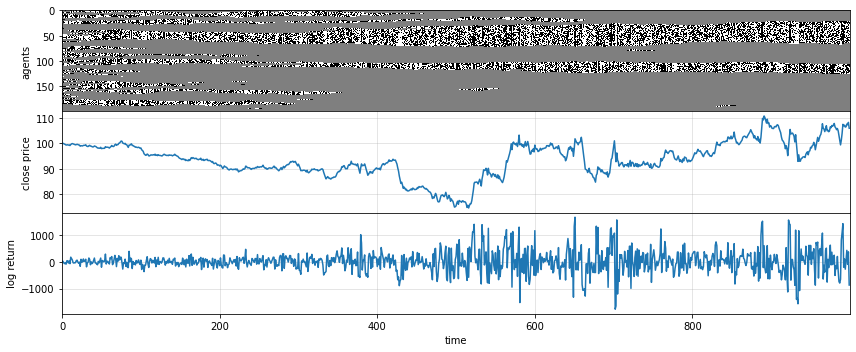

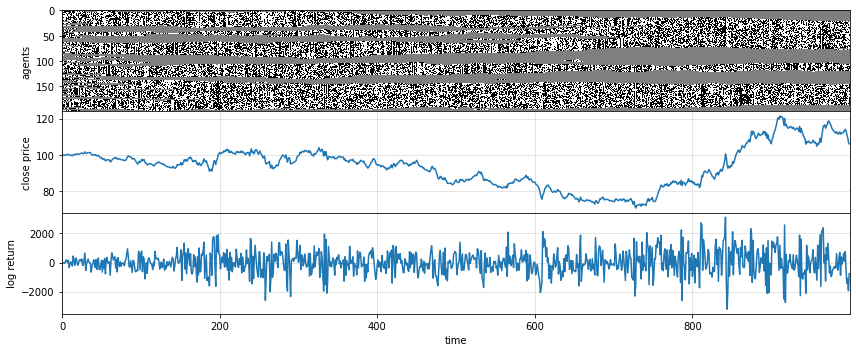

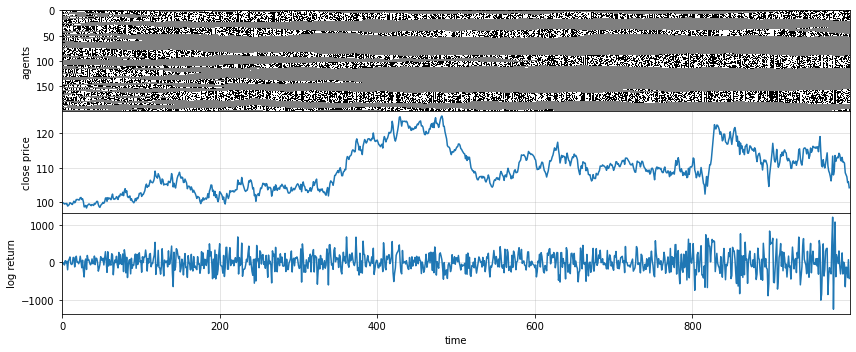

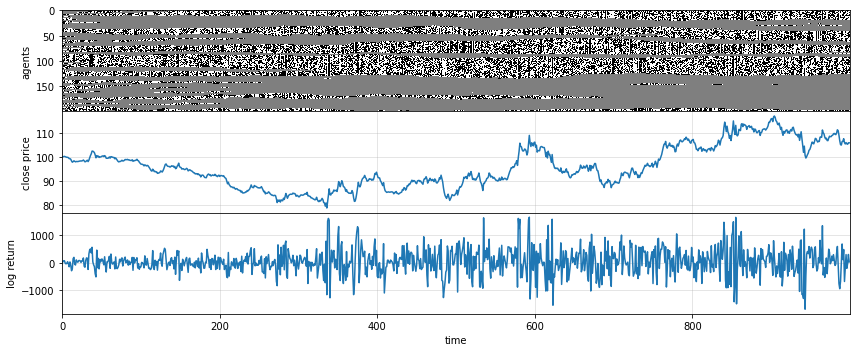

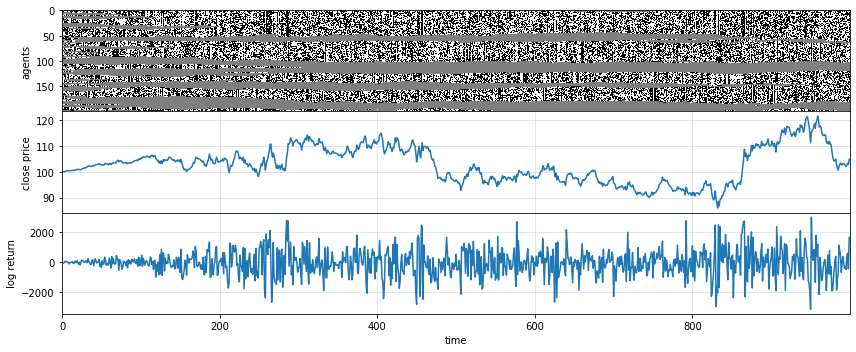

In [4]:
A_SPACE = np.linspace(1.8,2,1)
SIM = 5
plot = True

RVAR_STANDARD = np.zeros((len(A_SPACE), SIM))
RVAR = np.zeros((len(A_SPACE), SIM))
H = np.zeros((SIM, 50))

for j, A_val in enumerate(A_SPACE):
    for l in range(SIM):

        A = 1.8 # interaction strength between agents
        a = 2*A # randomness of A 
        h = 0  # external field reflecting the effects of the environmnet

        pd = 0.05  # probability that an active trader diffuses and becomes inactive
        pe = 0.0001 # probability that a nontrading enters the market
        ph = 0.0493 # probability that an active trader can turn one of his inactive neighbors into an active one
        pa = 0.5 # active and inactive distribution 

        N0 = 1000# timepoints
        N1 = 200 # granulization of the grid / agents

        

        G, RVAR_ARRAY = generate(pd, pe, ph, pa, N0, N1, A, a, h)
        RVAR[j, l]= np.sum(RVAR_ARRAY**2)
        
        # PLOT

        if plot ==True:
            x = RVAR_ARRAY

            fig, (ax1, ax2, ax3) = plt.subplots(
                ncols=1, nrows=3, figsize=(12,5), sharex=True, gridspec_kw = {'wspace':0, 'hspace':0}
            )
            ax1.imshow(G.T, cmap="binary", interpolation="None", aspect="auto")

            r = (x - np.mean(x)) / np.std(x)
            s = 100
            S = np.zeros_like(x)
            S[0] = s
            for i in range(1,N0):
                S[i] = S[i-1] + (S[i-1] * r[i]/100) + 0.01


            ax1.set_ylabel("agents")
            ax2.plot(S)
            ax2.grid(alpha=0.4)
            ax2.set_ylabel("close price")
            ax3.grid(alpha=0.4)
            ax3.plot(x)
            ax3.set_ylabel("log return")
            ax3.set_xlabel("time")
            plt.tight_layout()
            plt.show()

        x = RVAR_ARRAY

        r = (x - np.mean(x)) / np.std(x)

        s = 1400
        S = np.zeros_like(x)
        S[0] = s
        for i in range(1, N0):
             S[i] = S[i-1] + (S[i-1] * r[i]/100)

        _H_, Q = get_hurst_exponent(S, 100)
        H[l,:] = _H_
        # plt.plot(Q,_H_*Q, ".")
    # H_MEAN = np.mean(H,axis=0)
    # H_STD = np.std(H, axis=0)
    # clear_output(wait=True)
    # print(f"SIM{l}")


In [5]:
G

array([[ 0,  0,  1, ..., -1, -1,  0],
       [ 0,  1, -1, ...,  1,  1,  0],
       [ 0, -1,  1, ...,  1,  1,  0],
       ...,
       [ 0, -1,  1, ...,  0,  0,  0],
       [ 0, -1,  1, ...,  0,  0,  0],
       [ 0,  1,  1, ...,  0,  0,  0]], dtype=int16)

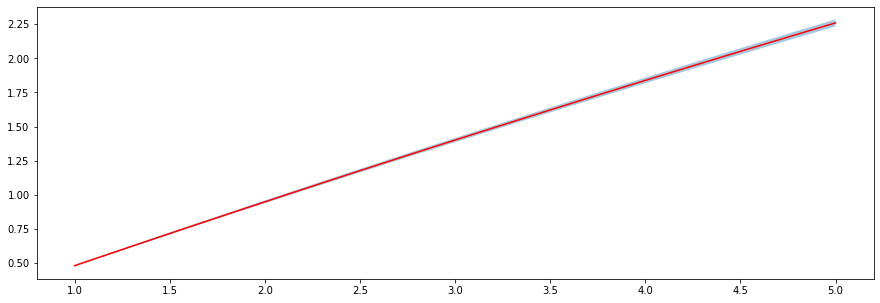

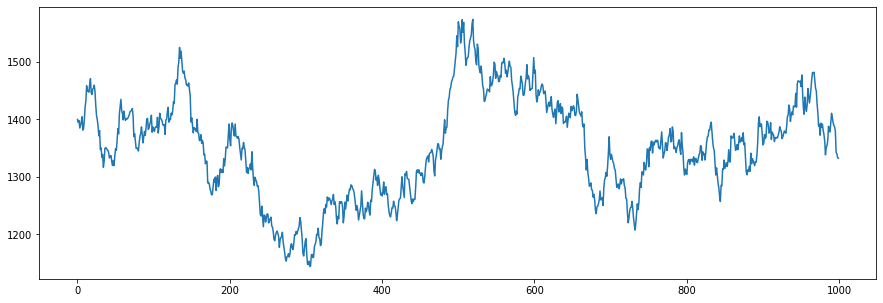

In [14]:
H_MEAN = np.mean(H,axis=0)
H_STD = np.std(H, axis=0)



Y1 = H_MEAN*Q+1.96*(H_STD)/np.sqrt(SIM)*H_MEAN*Q
Y2 = H_MEAN*Q-1.96*(H_STD)/np.sqrt(SIM)*H_MEAN*Q

plt.figure(figsize=(15,5))
plt.plot(Q, Q*H_MEAN, color="r")
plt.fill_between(x=Q, y1 =Y1, y2=Y2, alpha=0.4)
plt.show()

plt.figure(figsize=(15,5))
plt.plot(S)
plt.show()

<ipython-input-16-4f8392230e57>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_spx["Date"] = pd.to_datetime(df_spx["Date"], format='%d/%m/%Y')


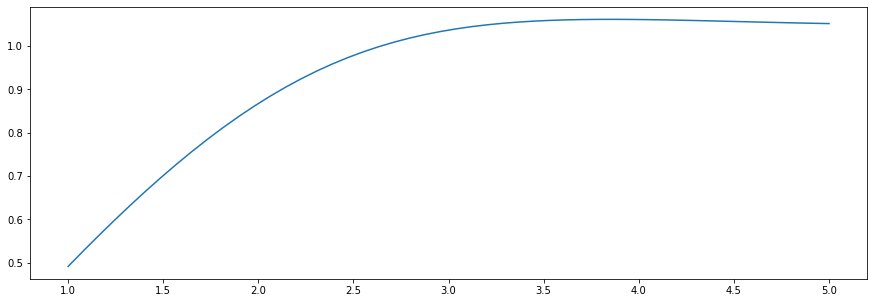

In [16]:
df = pd.read_csv("/Users/aleksander/Library/Mobile Documents/com~apple~CloudDocs/VSCODE/ComplexSystems/data/all_world_indices_clean.csv")


df_spx = df[["Date", "SPX Index"]]
df_spx["Date"] = pd.to_datetime(df_spx["Date"], format='%d/%m/%Y')
df_spx = df_spx.sort_values(by="Date")
df_spx.reset_index(inplace=True)
series_array = np.array(df_spx["SPX Index"])


H, Q = get_hurst_exponent(series_array, 100)

plt.figure(figsize=(15,5))
plt.plot(Q,H*Q)

In [20]:
x =RVAR_ARRAY

r = (x - np.mean(x)) / np.std(x)

s = 1400
S = np.zeros_like(x)
S[0] = s
for i in range(1, N0):
    S[i] = S[i-1] + (S[i-1] * r[i]/100)
for lag in [20, 100, 300, 500]:
    hurst_exp = get_hurst_exponent(S, lag)
    print(f"Hurst exponent with {lag} lags: {hurst_exp:.4f}")

TypeError: unsupported format string passed to numpy.ndarray.__format__

In [11]:
x =RVAR_ARRAY

r = (x - np.mean(x)) / np.std(x)

s = 1400
S = np.zeros_like(x)
S[0] = s
for i in range(1, N0):
    S[i] = S[i-1] + (S[i-1] * r[i]/100)

q_vals = np.linspace(1, 5, 30)
h_res = np.zeros(q_vals.shape[0])

for i, val in enumerate(q_vals):
    h_res[i] = genhurst(S, val)

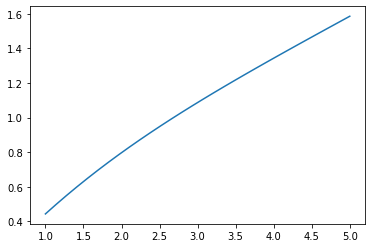

In [5]:
plt.plot(q_vals, q_vals*h_res)

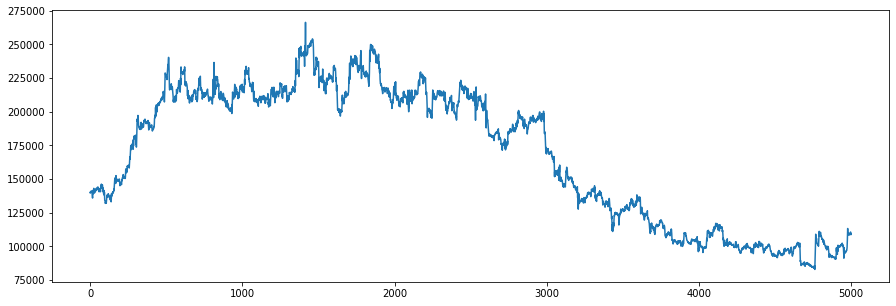

In [45]:
plt.figure(figsize=(15,5))
plt.plot(S)

# A PARAMETER

<ipython-input-7-a64e1e42d92f>:3: RuntimeWarning: invalid value encountered in true_divide
  RVAR_STD= RVAR_STD/np.max(RVAR_STD)


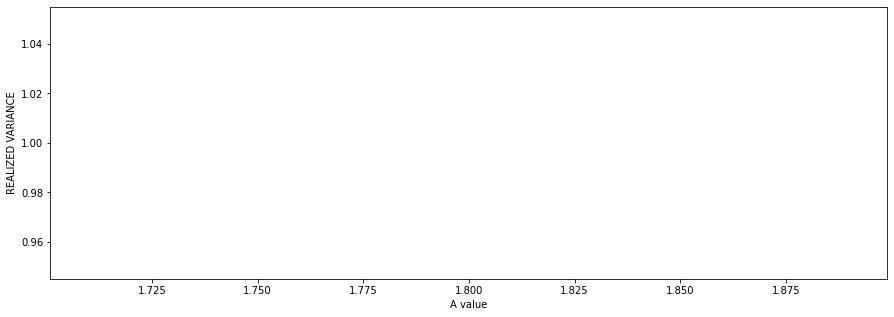

In [7]:
RVAR_MEAN = np.mean(RVAR, axis=1)
RVAR_STD = np.std(RVAR, axis=1)
RVAR_STD= RVAR_STD/np.max(RVAR_STD)

Y1 = RVAR_MEAN/np.max(RVAR_MEAN)+1.96*(RVAR_STD)/np.sqrt(SIM)
Y2 = RVAR_MEAN/np.max(RVAR_MEAN)-1.96*(RVAR_STD)/np.sqrt(SIM)

plt.figure(figsize=(15,5))
plt.plot(A_SPACE, RVAR_MEAN/np.max(RVAR_MEAN), color="r")
plt.fill_between(x=A_SPACE, y1 =Y1, y2=Y2)
plt.xlabel("A value")
plt.ylabel("REALIZED VARIANCE")
plt.show()

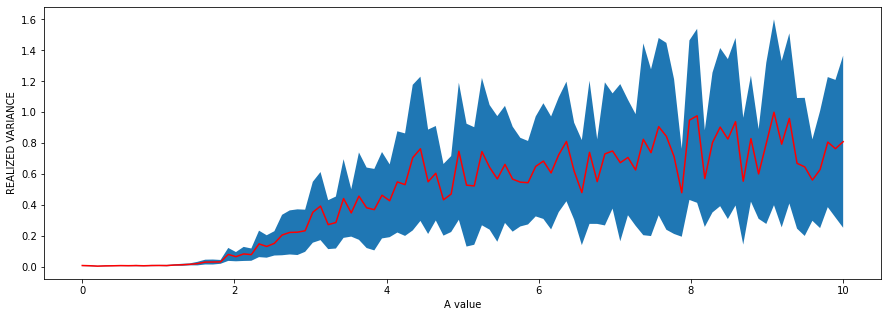

In [50]:
RVAR2 = np.load("CA_100sim_2000N0_Arange(0,10,100).npy")
RVAR_MEAN2 = np.mean(RVAR2, axis=1)
RVAR_STD2 = np.std(RVAR2, axis=1)
RVAR_STD2= RVAR_STD2/np.max(RVAR_STD2)

Y1 = RVAR_MEAN2/np.max(RVAR_MEAN2)+1.96*(RVAR_STD2)/np.sqrt(100)
Y2 = RVAR_MEAN2/np.max(RVAR_MEAN2)-1.96*(RVAR_STD2)/np.sqrt(100)

plt.figure(figsize=(15,5))
plt.plot(A_SPACE, RVAR_MEAN2/np.max(RVAR_MEAN2), color="r")
plt.fill_between(x=A_SPACE, y1 =Y1, y2=Y2)
plt.xlabel("A value")
plt.ylabel("REALIZED VARIANCE")
plt.show()

In [31]:
RVAR_STD/np.max(RVAR_STD)

array([0.00584158, 0.00571303, 0.00320149, 0.00475359, 0.00417657,
       0.00584396, 0.00538863, 0.00661943, 0.00578196, 0.00642858,
       0.00609171, 0.00706218, 0.00741085, 0.01042487, 0.01015188,
       0.01844671, 0.02486581, 0.02588914, 0.02000337, 0.06757933,
       0.04816633, 0.07328812, 0.06414542, 0.13790712, 0.11692119,
       0.12678924, 0.21085994, 0.22974711, 0.23818516, 0.21968952,
       0.31755251, 0.35496538, 0.25512716, 0.2709177 , 0.41021272,
       0.24710349, 0.45537897, 0.41953565, 0.4248095 , 0.45056887,
       0.379586  , 0.52787195, 0.53438624, 0.75921353, 0.7520063 ,
       0.5441365 , 0.49256193, 0.37358759, 0.39587307, 0.714683  ,
       0.64042273, 0.61286482, 0.76827041, 0.64980614, 0.65493378,
       0.61037828, 0.54755907, 0.46207664, 0.43516167, 0.52105354,
       0.60309771, 0.58886381, 0.59832863, 0.62348787, 0.505319  ,
       0.54770249, 0.74609431, 0.44077808, 0.74589048, 0.6005528 ,
       0.81958165, 0.60248676, 0.58210863, 1.        , 0.86949